In [52]:
import numpy as np
import matplotlib.pyplot as plt
from utils.EnvironmentBasics import Environment, Action, State
from utils.GridWorld import GridWorld
from utils.AgentBasics import Agent, Policy
from tqdm import tqdm
from typing import *

# Monte Carlo Method
- 不知道环境如何，或者环境太复杂，state太多，你别想遍历这么多。
- 完全从实践和经验中学习，无数次的探索，然后学习。
- 跟模拟算法是天生的一对。

## First-Visit Monte Carlo Prediction
- 想知道state s遵循policy $\pi$的state-value，$v_\pi(s)$
- 已知有好多episode都经过了s，每次经过s叫做a visit to state s，第一次经过s就叫做first-visit to state s。
- 简单讲，就是每次我到过state s之后都是什么后果，我都给你记着，然后你这个state的好坏就是对我这些后果的平均值。

1. 定义 float Returns\[n_state\]
2. 生成或取得一个episode，即从start state一直到terminal state。
3. G = 0
4. 从后往前循环episode的每一步，得到$(S_{t-1}, A_{t-1}, R_t)$
5. 累积当前state的return $G = \gamma G + R_t$
6. 如果这个state不是这个episode的first-visit，就跳过，否则Returns\[s\].append(G)
7. 回到1
8. 如果你觉得足够了，就停止循环，此时Returns\[s\]是一个list，里面有很多G，它记录着每次经过s得到的未来return，然后求平均值就是$v_\pi(s)$，即一个对state s未来可能取得的return的估计。

首先重写一下GridWorld类，让它的state可以给多个不同的reward，对于普通state，reward在0-1区间，而对于terminal state，其reward在2-3区间

In [53]:
class GridWorldDynamicReward(Environment):
    def __init__(self, world_size: int, terminal_states: List[Tuple[int, int]] = None):
        """ Rewrite GridWorld class, make state rewards more random

        :param world_size: size of the world
        """
        state_space = []
        for row in range(world_size):
            for col in range(world_size):
                is_terminal = (row, col) in terminal_states
                # NOLY TERMINAL STATES HAVE REWARDS !!!
                # IF OTHER STATES HAVE REWARDS, THE AGENT WILL BE CONFUSED !!!
                # CAUSION !!! CAUSION !!! CAUSION !!!
                rewards = np.random.rand(4) * is_terminal
                state_space.append(State(f"({row},{col})", rewards=rewards, is_terminal=is_terminal))
        action_space = [Action("left"), Action("right"), Action("down"), Action("up")]
        super().__init__(state_space, action_space)

        self.world_size = world_size
        self.n_grids = world_size ** 2
        self.grid_rowid = np.arange(self.n_grids)//self.world_size
        self.grid_colid = np.arange(self.n_grids)%self.world_size

        setattr(self.__class__, "stateIdToCoord", GridWorld.stateIdToCoord)
        setattr(self.__class__, "coordToStateId", GridWorld.coordToStateId)

        # Define transitions of the grid world
        state_id = 0
        for row in range(world_size):
            for col in range(world_size):
                self.setStateTransition(state_id, 0, self.coordToStateId(row, (col-1) % world_size), 1)  # left
                self.setStateTransition(state_id, 1, self.coordToStateId(row, (col+1) % world_size), 1)  # right
                self.setStateTransition(state_id, 2, self.coordToStateId((row-1) % world_size, col), 1)  # down
                self.setStateTransition(state_id, 3, self.coordToStateId((row+1) % world_size, col), 1)  # up
                state_id += 1

        setattr(self.__class__, "highlightTerminalStates", GridWorld.highlightTerminalStates)
        setattr(self.__class__, "isTerminalCoord", GridWorld.isTerminalCoord)
        setattr(self.__class__, "getReward", GridWorld.getReward)

    def render(self, agent:Agent=None, figsize:Tuple[int, int]=None):
        """ Render the environment, override method in Environment class
        1. draw the states as grids
        2. no need to draw transitions, because they are obvious in the grid world
        3. highlight current state
        4. highlight start state
        5. highlight terminal states
        """
        if figsize is None:
            figsize = (5, 5)
        plt.figure(figsize=figsize)

        plt.xlim(-1, self.world_size)
        plt.ylim(-1, self.world_size)
        color = agent.state_value if agent is not None else [state.is_terminal for state in self.states]
        plt.scatter(self.grid_colid, self.grid_rowid, c=color, marker="s", s=1000, alpha=0.75)
        # for gi in range(self.n_grids):
        #     label = f"{agent.state_value[gi] if agent is not None else self.states[gi].is_terminal:.2f}"
        #     plt.annotate(label, (self.grid_colid[gi], self.grid_rowid[gi]), textcoords="offset points", xytext=(2, -2), ha="center")

        self.highlightTerminalStates()
        if agent is not None:
            for sid in range(self.n_states):
                if not self.isTerminalState(sid):
                    for action in self.getValidActionIds(sid):
                        row, col = self.stateIdToCoord(sid)
                        self.drawArrow(col, row, action, agent.policy[sid, action])

    def drawArrow(self, x: int, y: int, action: Union[Action, int], length: float = 1):
        """ Draw an arrow from point x, y, direction code: {0: "left", 1: "right", 2: "down", 3: "up"} """
        if not isinstance(action, Action):
            action = self.aid_to_action[action]
        dx, dy = 0, 0
        if action.name == "left":
            dx = -0.5 * length
        elif action.name == "right":
            dx = 0.5 * length
        elif action.name == "down":
            dy = -0.5 * length
        elif action.name == "up":
            dy = 0.5 * length

        plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, length_includes_head=True)

First-Visit Monte Carlo Prediction

Monte Carlo: 100%|██████████| 2000/2000 [00:00<00:00, 3293.33it/s]


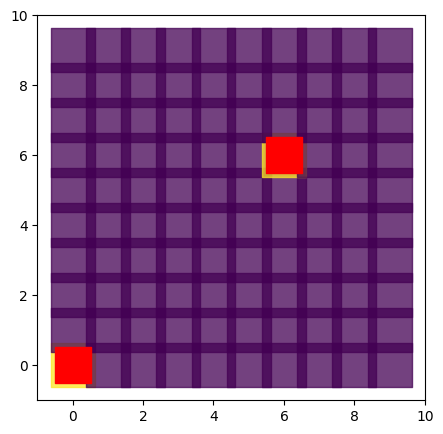

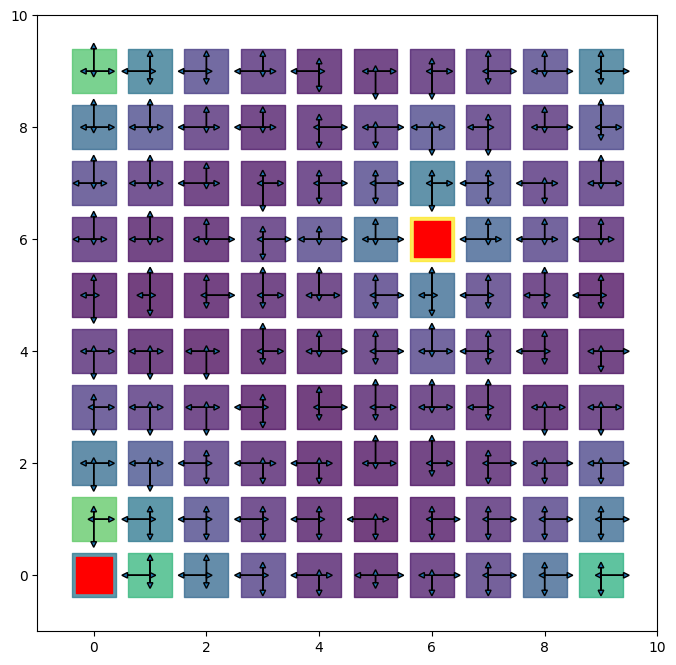

In [54]:
def firstVisionMC(grid_world: GridWorldDynamicReward):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    for sid in grid_world.getTerminalStateIds():
        agent.state_value[sid] = grid_world.states[sid].getReward()
    gamma = 0.6

    grid_world.render()

    # Monte Carlo
    # Keep track of the sum of returns G for each state to calculate an average.
    state_return_sum = np.zeros(grid_world.n_states)
    # The number of times each state has been visited. (First visit)
    state_visit_count = np.zeros(grid_world.n_states)
    for it in tqdm(range(2000), desc="Monte Carlo"):
        # Generate episode
        grid_world.reset()  # reset with a random start state
        episode_states = [grid_world.start_sid]
        episode_actions = []
        episode_rewards = []
        is_terminal = grid_world.isTerminalState(grid_world.start_sid)
        while not is_terminal:
            random_action_id = agent.takeAction(grid_world.current_sid, epsilon=0.3)
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            episode_actions.append(random_action_id)
            next_sid, r, is_terminal = grid_world.step(random_action_id)
            episode_rewards.append(r)
            episode_states.append(next_sid)
        episode_states = episode_states[:-1]  # remove the last state, which is terminal state


        # Loop state backward to update state value
        G = 0
        for t in range(len(episode_states)-1, -1, -1):
            G = gamma * G + episode_rewards[t]
            if episode_states[t] not in episode_states[:t]:     # check for first visit
                state_return_sum[episode_states[t]] += G
                state_visit_count[episode_states[t]] += 1
                # Update state value
                agent.state_value[episode_states[t]] = state_return_sum[episode_states[t]] / state_visit_count[episode_states[t]]
                # Update policy

                for aid in range(grid_world.n_actions):
                    next_sid = np.where(grid_world.getNextStateProbs(episode_states[t], aid) == 1)[0][0]     # only one next state
                    agent.policy[episode_states[t], aid] = agent.state_value[next_sid]

    agent.policy.rankNormalize()

    grid_world.render(agent, figsize=(8, 8))
    plt.show()


firstVisionMC(GridWorldDynamicReward(10, [(0, 0), (6, 6)]))
        

奇怪，这个Monte Carlo方法怎么这么不稳定？？？<p>
一开始，这个很不稳定，是因为我在初始化state space时，将非terminal state的reward设成了0-1区间，terminal state的reward更高，为2-3区间。但这样会导致局部地区有很高的reward，而这个reward是随机的，所以会导致agent在这个地方不断地探索，而不是去探索其他地方。所以我将所有非terminal state的reward都设为0，这样就不会有这个问题了。
